In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import math
import matplotlib.gridspec as gridspec
from plotting import newfig
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
from scipy.interpolate import griddata
from eager_lbfgs import lbfgs, Struct
from pyDOE import lhs
import os
import random

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib.ticker import AutoMinorLocator,MultipleLocator,FuncFormatter
import matplotlib.ticker as ticker

In [4]:
random_seed = 1232
random.seed(random_seed )  # set random seed for python
np.random.seed(random_seed )  # set random seed for numpy
tf.random.set_seed(random_seed )  # set random seed for tensorflow-cpu

In [5]:
layer_sizes = [2,50,50,50,50,1]  

In [6]:
sizes_w = []
sizes_b = []
for i, width in enumerate(layer_sizes):
    if i != 1:
        sizes_w.append(int(width * layer_sizes[1]))
        sizes_b.append(int(width if i != 0 else layer_sizes[1]))

def set_weights(model, w, sizes_w, sizes_b):
        for i, layer in enumerate(model.layers[0:]):
            start_weights = sum(sizes_w[:i]) + sum(sizes_b[:i])
            end_weights = sum(sizes_w[:i+1]) + sum(sizes_b[:i])
            weights = w[start_weights:end_weights]
            w_div = int(sizes_w[i] / sizes_b[i])
            weights = tf.reshape(weights, [w_div, sizes_b[i]])
            biases = w[end_weights:end_weights + sizes_b[i]]
            weights_biases = [weights, biases]
            layer.set_weights(weights_biases)



def get_weights(model):
        w = []
        for layer in model.layers[0:]:
            weights_biases = layer.get_weights()
            weights = weights_biases[0].flatten()
            biases = weights_biases[1]
            w.extend(weights)
            w.extend(biases)

        w = tf.convert_to_tensor(w)
        return w


def neural_net(layer_sizes):
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(layer_sizes[0],)))
    for width in layer_sizes[1:-1]:
        model.add(layers.Dense(
            width, activation=tf.nn.tanh,
            kernel_initializer="glorot_normal"))
    model.add(layers.Dense(
            layer_sizes[-1], activation=None,
            kernel_initializer="glorot_normal"))
    return model


u_model = neural_net(layer_sizes)

u_model.summary()


def loss(x_f_batch, t_f_batch,
             x0, t0, u0, x_lb,
             t_lb, x_ub, t_ub, col_weights, u_weights):

    f_u_pred = f_model(x_f_batch, t_f_batch)
    u0_pred = u_model(tf.concat([x0, t0],1))
    u_lb_pred, _ = u_x_model(x_lb, t_lb)
    u_ub_pred, _ = u_x_model(x_ub, t_ub)

    mse_0_u = tf.reduce_mean(tf.square(u_weights*(u0 - u0_pred)))

    
    mse_0_uchushi = tf.reduce_mean(tf.square(1*(u0 - u0_pred)))    
    
    
    mse_b_u = tf.reduce_mean(tf.square(u_lb_pred - 0)) + \
            tf.reduce_mean(tf.square(u_ub_pred - 0)) #since ub/lb is 0

    mse_f_u = tf.reduce_mean(tf.square(col_weights*f_u_pred))
    
    mse_f_uchushi = tf.reduce_mean(tf.square(1*f_u_pred))

    return  mse_0_u + mse_b_u + mse_f_u , mse_0_uchushi, mse_f_uchushi


@tf.function
def f_model(x,t):
    u = u_model(tf.concat([x,t], 1))
    u_x = tf.gradients(u,x)
    u_xx = tf.gradients(u_x, x)
    u_t = tf.gradients(u,t)
    
    hhhhhh=tf.constant(0.15)
    a=tf.constant(1.0)
    b=tf.constant(2.0)
    c=tf.constant(4.0)
    #f_u=u_t-u_xx-b*tf.exp(a/((b*t-a)*(b*t-a)+hhhhhh))+tf.exp(a/((b*t-a)*(b*t-a)+hhhhhh))*(a-x*x)*c*(b*t-a)/((b*t-a)*(b*t-a)+hhhhhh)/((b*t-a)*(b*t-a)+hhhhhh)
    f_u = u_t  - (1/tf.constant(1.0))*u_xx - b*tf.exp(a/((b*t-a)*(b*t-a)+hhhhhh)) +tf.exp(a/((b*t-a)*(b*t-a)+hhhhhh))*(a-x*x)*c*(b*t-a)/((b*t-a)*(b*t-a)+hhhhhh)/((b*t-a)*(b*t-a)+hhhhhh)
    return f_u



@tf.function
def u_x_model(x,t):
    u = u_model(tf.concat([x,t],1))
    u_x = tf.gradients(u,x)
    return u,u_x

@tf.function
def grad(model, x_f_batch, t_f_batch, x0_batch, t0_batch, u0_batch, x_lb, t_lb, x_ub, t_ub, col_weights, u_weights):
    with tf.GradientTape(persistent=True) as tape:
        #tape.watch(col_weights)
        #tape.watch(u_weights)
        loss_value, mse_0, mse_f = loss(x_f_batch, t_f_batch, x0_batch, t0_batch, u0_batch, x_lb, t_lb, x_ub, t_ub, col_weights, u_weights)
        grads = tape.gradient(loss_value, u_model.trainable_variables)
        #print(grads)
        grads_col = tape.gradient(loss_value, col_weights)
        grads_u = tape.gradient(loss_value, u_weights)

    return loss_value, mse_0, mse_f, grads, grads_col, grads_u

def fit(x_f, t_f, x0, t0, u0, x_lb, t_lb, x_ub, t_ub, col_weights, u_weights, tf_iter, newton_iter):
    # Built in support for mini-batch, set to N_f (i.e. full batch) by default
    batch_sz = N_f
    n_batches =  N_f // batch_sz
    start_time = time.time()
    tf_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1=.90)
    tf_optimizer_coll = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1=.90)
    tf_optimizer_u = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1=.90)

    print("starting Adam training")

    for epoch in range(tf_iter):
        for i in range(n_batches):

            x0_batch = x0#[i*batch_sz:(i*batch_sz + batch_sz),]
            t0_batch = t0#[i*batch_sz:(i*batch_sz + batch_sz),]
            u0_batch = u0#[i*batch_sz:(i*batch_sz + batch_sz),]

            x_f_batch = x_f[i*batch_sz:(i*batch_sz + batch_sz),]
            t_f_batch = t_f[i*batch_sz:(i*batch_sz + batch_sz),]

            loss_value,mse_0, mse_f, grads, grads_col, grads_u = grad(u_model, x_f_batch, t_f_batch, x0_batch, t0_batch, u0_batch, x_lb, t_lb, x_ub, t_ub, col_weights, u_weights)

            tf_optimizer.apply_gradients(zip(grads, u_model.trainable_variables))
            tf_optimizer_coll.apply_gradients(zip([-grads_col], [col_weights]))
            tf_optimizer_u.apply_gradients(zip([-grads_u], [u_weights]))


        if epoch % 200 == 0:
            elapsed = time.time() - start_time
            print('It: %d, Time: %.2f' % (epoch, elapsed))
            tf.print(f"mse_0: {mse_0}  mse_f: {mse_f}   total loss: {loss_value}")
            start_time = time.time()


    #l-bfgs-b optimization
    print("Starting L-BFGS training")

    loss_and_flat_grad = get_loss_and_flat_grad(x_f_batch, t_f_batch, x0_batch, t0_batch, u0_batch, x_lb, t_lb, x_ub, t_ub, col_weights, u_weights)

    lbfgs(loss_and_flat_grad,
      get_weights(u_model),
      Struct(), maxIter=newton_iter, learningRate=0.8)


# L-BFGS implementation from https://github.com/pierremtb/PINNs-TF2.0
def get_loss_and_flat_grad(x_f_batch, t_f_batch, x0_batch, t0_batch, u0_batch, x_lb, t_lb, x_ub, t_ub, col_weights, u_weights):
    def loss_and_flat_grad(w):
        with tf.GradientTape() as tape:
            set_weights(u_model, w, sizes_w, sizes_b)
            loss_value, _, _ = loss(x_f_batch, t_f_batch, x0_batch, t0_batch, u0_batch, x_lb, t_lb, x_ub, t_ub, col_weights, u_weights)
        grad = tape.gradient(loss_value, u_model.trainable_variables)
        grad_flat = []
        for g in grad:
            grad_flat.append(tf.reshape(g, [-1]))
        grad_flat = tf.concat(grad_flat, 0)
        #print(loss_value, grad_flat)
        return loss_value, grad_flat

    return loss_and_flat_grad


def predict(X_star):
    X_star = tf.convert_to_tensor(X_star, dtype=tf.float32)
    u_star, _ = u_x_model(X_star[:,0:1],
                     X_star[:,1:2])

    f_u_star = f_model(X_star[:,0:1],
                 X_star[:,1:2])

    return u_star.numpy(), f_u_star.numpy()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                150       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7,851
Trainable params: 7,851
Non-trainable params: 0
_________________________________________________________________


In [7]:
def heatsolution(x,t):
    return math.exp(1/((2*t-1)**2+0.15))*(1-x**2)

In [8]:
lb = np.array([-1.0]) #x upper boundary
ub = np.array([1.0]) #x lower boundary

N0 = 1200
N_b = 1200 #25 per upper and lower boundary, so 50 total
N_f = 10000

col_weights = tf.Variable(tf.random.uniform([N_f, 1]))
u_weights = tf.Variable(tf.reshape(tf.repeat(100.0, N0),(N0, -1)))

x=np.linspace(-1,1,1200).flatten()[:,None]   
t=np.linspace(0,1,1200).flatten()[:,None]   
res=np.zeros([len(x),len(t)])  
for i in range(len(x)):
    for j in range(len(t)):
        res[i,j]=heatsolution(x[i],t[j])
Exact_u = res


#grab random points off the initial condition
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
u0 = tf.cast(Exact_u[idx_x,0:1], dtype = tf.float32)

idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]

# Sample collocation points via LHS
X_f = lb + (ub-lb)*lhs(2, N_f)

x_f = tf.convert_to_tensor(X_f[:,0:1], dtype=tf.float32)
t_f = tf.convert_to_tensor(np.abs(X_f[:,1:2]), dtype=tf.float32)


#generate point vectors for training
X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)

#seperate point vectors
x0 = tf.cast(X0[:,0:1], dtype = tf.float32)
t0 = tf.cast(X0[:,1:2], dtype = tf.float32)

x_lb = tf.convert_to_tensor(X_lb[:,0:1], dtype=tf.float32)
t_lb = tf.convert_to_tensor(X_lb[:,1:2], dtype=tf.float32)

x_ub = tf.convert_to_tensor(X_ub[:,0:1], dtype=tf.float32)
t_ub = tf.convert_to_tensor(X_ub[:,1:2], dtype=tf.float32)




In [9]:
fit(x_f, t_f, x0, t0, u0, x_lb, t_lb, x_ub, t_ub, col_weights, u_weights, tf_iter = 2000, newton_iter = 40000)

starting Adam training
It: 0, Time: 5.23
mse_0: 3.03354811668396  mse_f: 4779372.5   total loss: 1583466.5
It: 200, Time: 11.74
mse_0: 0.492075651884079  mse_f: 2940947.25   total loss: 8592778.0
It: 400, Time: 11.76
mse_0: 1.2395837306976318  mse_f: 1437090.375   total loss: 11490563.0
It: 600, Time: 11.77
mse_0: 6.7351393699646  mse_f: 757218.6875   total loss: 11963056.0
It: 800, Time: 11.70
mse_0: 1.8756356239318848  mse_f: 422373.875   total loss: 9232163.0
It: 1000, Time: 11.98
mse_0: 3.3388571739196777  mse_f: 233331.640625   total loss: 6676998.5
It: 1200, Time: 11.90
mse_0: 2.417386770248413  mse_f: 205174.125   total loss: 6237435.5
It: 1400, Time: 11.71
mse_0: 2.8814570903778076  mse_f: 126680.9765625   total loss: 4690702.5
It: 1600, Time: 11.74
mse_0: 1.3844854831695557  mse_f: 55668.8125   total loss: 2545142.25
It: 1800, Time: 11.74
mse_0: 1.2674047946929932  mse_f: 28577.984375   total loss: 1455037.75
Starting L-BFGS training
Step 1000 loss 140265.31250 
Step 2000 loss

In [10]:
#generate mesh to find U0-pred for the whole domain
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]

lb = np.array([-1.0, 0.0])
ub = np.array([1.0, 1])

# Get preds
u_pred, f_u_pred = predict(X_star)

#find L2 error
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))

Error u: 1.757298e-03


In [11]:
error_u1 = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_u2 = np.linalg.norm(u_star-u_pred,1)/len(u_star)
error_u3 = np.linalg.norm(u_star-u_pred,np.inf)
print('二范数Error u: %e' % (error_u1))
print('平均绝对Error u: %e' % (error_u2))
print('无穷范数Error u: %e' % (error_u3))

二范数Error u: 1.757298e-03
平均绝对Error u: 1.877567e-01
无穷范数Error u: 2.227389e+00


In [12]:
scipy.io.savemat("1.mat", {'u': u_pred})

In [13]:
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

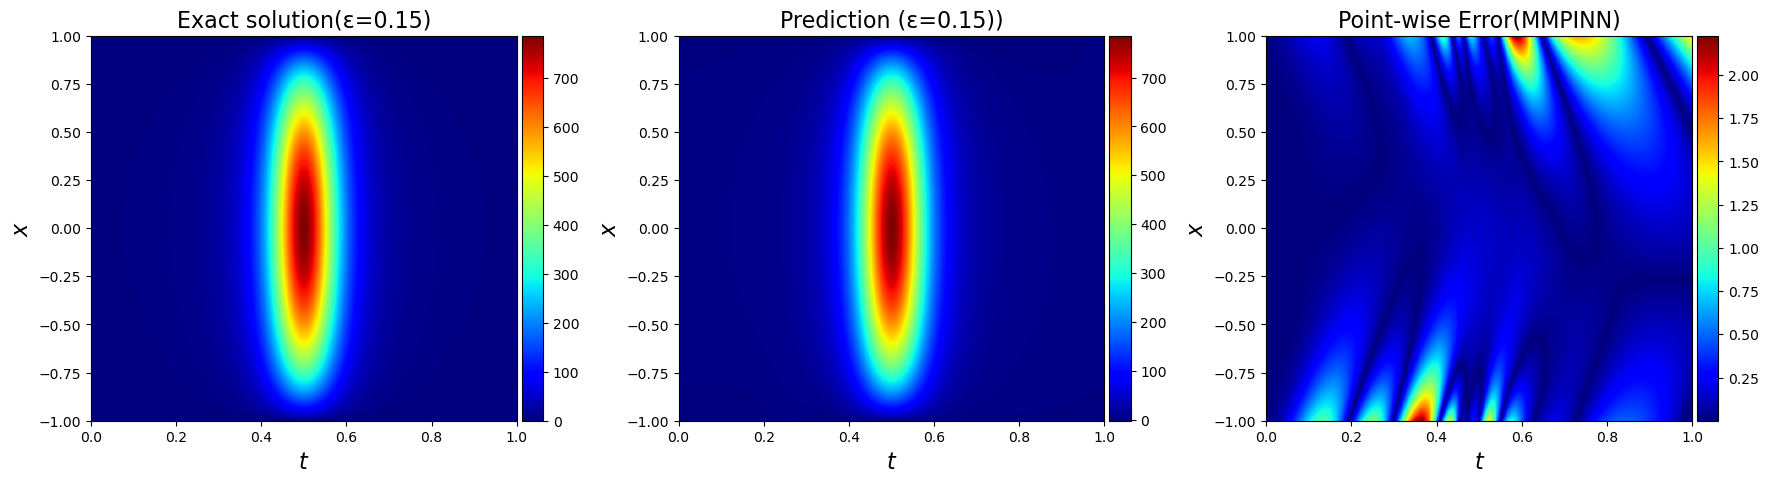

In [15]:
    from matplotlib.colors import LogNorm
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    fig.subplots_adjust(wspace=0.3)  # 调整子图之间的水平间距

    # 第一个子图
    ax1 = axs[0]    
    h = ax1.imshow(Exact_u, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax1.set_title('Exact solution(ε=0.15)', fontsize=16)
    ax1.set_xlabel('$t$', fontsize=16)
    ax1.set_ylabel('$x$', fontsize=16)
    #左边的色差图
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    
    ax2 = axs[1]    
    h = ax2.imshow(U_pred.T, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax2.set_title('Prediction (ε=0.15))', fontsize=16)
    ax2.set_xlabel('$t$', fontsize=16)
    ax2.set_ylabel('$x$', fontsize=16)
    #左边的色差图
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    
    ax3 = axs[2]    
    h = ax3.imshow(np.abs(U_pred.T-Exact_u), interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax3.set_title(r'Point-wise Error(MMPINN)', fontsize=16 )
    ax3.set_xlabel('$t$', fontsize=16)
    ax3.set_ylabel('$x$', fontsize=16)
    #左边的色差图
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)    
    
    
    #plt.savefig('Waterasdes.jpg', dpi=500, bbox_inches='tight') # 解决图片不清晰，不完整的问题
    #plt.savefig('0.15 exact solution and point wise error by mmpinn and standard.pdf', bbox_inches='tight') 
    plt.show() 